In [106]:
import pandas as pd
from pandas import concat
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
import random
import tensorflow as tf



class AutoCNN():
    
    '''
    Vector Autoregression model

    Attributes
    ----------
    self.data_backup: dataframe, a backup copy of the input dataset
    self.data: dataframe, the main dataset worked on
    self.n: int, length (unit in months) of target to predict
    self.df_result: dataframe, stores the predicted target and the true target
    self.lag: int, number of past months used to predict the target
    self.rmse: rounded RMSE of the prediction
    self.target: str, name of target variable
    self.model: record a CNN trained model
    self.train_result: record model fit result loss
    
    Params
    ----------
    data_name: str, name of the dataset. Notice the input dataset must contain a column named 'Date'
    target_name: str, name of target variable
    drop_cols: list of strings, names of columns to drop
    '''
    def __init__(self, data_name, target_name, drop_cols=['Date']):   
        #import data
        curr_path = os.getcwd()
        input_path = os.path.join(curr_path, data_name)
        data = pd.read_excel(input_path, index_col=0)
        
        #drop columns and na
        data.drop(drop_cols, axis=1, inplace=True)
        data.dropna(inplace = True)
        # data.reset_index(drop=True, inplace=True)
        
        #set attributes
        self.data = data
        self.n = 1
        self.df_result = 0
        self.lag = 0
        self.column_name = []
        self.rmse = 0
        self.target = target_name
        self.n_features = len(data.columns) - 1
        self.model = 0
        self.train_result = 0
        self.y_p=[]
        self.y_t=[]
        
    def series_to_supervised(self, data, n_in=1, n_out=1, dropnan=True, if_target=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        df_without_target = df.loc[:, df.columns[1:]]
        cols, names = list(), list()
        if if_target:
            for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
            for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            agg = concat(cols, axis=1)
            agg.columns = names
            
        else:
            for i in range(n_in, 0, -1):
                cols.append(df_without_target.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(1, n_vars)]
            for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            agg = concat(cols, axis=1)
            agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    

    def get_predict(self, forward=24):
        pred_y_list = []
        for i in range(len(self.lags)):
            # get predict input
            self.get_pred_data(i)
            model = self.models[i]
            #values = self.values_24[i]

            test_X = self.predX

            # reshape input to be 3D [samples, timesteps, features]
            #test_X = test_X.reshape((1, 1, len(test_X)))
            test_X_reshaped = np.array(test_X).reshape(1, self.lags[i], self.n_features+1, 1)
            pred_y = model.predict(test_X_reshaped)
            
            test_X = test_X.reshape((1, 1, len(test_X)))
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            pred_y = pred_y.reshape((len(pred_y), 1))

            inv_yhat = np.concatenate((pred_y, test_X[:, 1:self.n_features+1]), axis=1)
            inv_yhat = self.scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,0]
            # invert scaling for actual

            pred_y_list.append(inv_yhat[0])

        return pred_y_list

    
    def get_pred_data(self,i):
                # last reframed data for prediction input
        reframed_predX = self.series_to_supervised(self.scaled, self.lags[i], self.leads[0], False, True)
        reframed_predX.drop(reframed_predX.columns[range(reframed_predX.shape[1] - self.n_features, reframed_predX.shape[1])], axis=1, inplace=True)
        reframed_predX.drop(reframed_predX.columns[range(reframed_predX.shape[1] - 1 - (self.leads[0] - 1) * (self.n_features + 1), reframed_predX.shape[1]-1)], axis=1, inplace=True)

        self.predX = reframed_predX.iloc[-1,0:-1].values
    
    def run(self, use_target=True, lags=[], leads=[]): 
        def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
        self.models=[]
        self.values_24=[]
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(self.data)
        
        self.scaled = scaled
        self.scaler = scaler
        self.leads=leads
        self.lags=lags
        
        pred_y_list = []
        true_y_list = []
        n = 1
        n_loop = 1
        for i in range(len(lags)):
            #pred_begin_date = timearray[i]
            lag = lags[i]
            lead = leads[i]
            reframed = self.series_to_supervised(scaled, lag, lead, True, use_target)
            reframed.drop(reframed.columns[range(reframed.shape[1] - self.n_features, reframed.shape[1])], axis=1, inplace=True)
            reframed.drop(reframed.columns[range(reframed.shape[1] - 1 - (lead - 1) * (self.n_features + 1), reframed.shape[1]-1)], axis=1, inplace=True)
        
            values = reframed.values
            self.values_24.append(values)
            
            #self.n = 1

            #test_date_begin = self.data.index.get_loc(pred_begin_date) - lag - lead + 1
            #train = values[:test_date_begin, :]
            #test = values[test_date_begin: test_date_begin+self.n, :]

            # split into input and outputs
            #train_X, train_y = train[:, :-1], train[:, -1]
            #test_X, test_y = test[:, :-1], test[:, -1]
            
            
            X, y= values[:,:-1], values[:,-1]
            X_reshaped = np.array(X).reshape(len(X), lag, self.n_features+1, 1)
            # reshape data and normalize data
            #if use_target:
               # features  = self.n_features+1
                #train_X_reshaped = np.array(train_X).reshape(len(train_X), lag, self.n_features+1, 1)
                #test_X_reshaped = np.array(test_X).reshape(len(test_X), lag, self.n_features+1, 1)
            #else:
               # features = self.n_features
               # train_X_reshaped = np.array(train_X).reshape(len(train_X), lag, self.n_features, 1)
               # test_X_reshaped = np.array(test_X).reshape(len(test_X), lag, self.n_features, 1)            

            #build CNN model
            model = Sequential()
            model.add(Conv2D(filters = 32, 
                             input_shape = ((lag, self.n_features+1, 1)),
                             data_format = 'channels_last',
                             kernel_size=(2,2), 
                             strides=(1,1),   
                             activation='relu'))
            #model.add(MaxPooling2D(pool_size=(2, 1)))
            #model.add(AveragePooling2D(pool_size=(2,1)))
            model.add(Flatten())
            model.add(Dense(45, activation='relu'))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss=root_mean_squared_error)
            result = model.fit(X_reshaped, y, verbose=0, epochs=20) 
            self.models.append(model)
            
            '''
            inv_yhat_list=[]
            for j in range(n_loop):
                result = model.fit(train_X_reshaped, train_y, verbose=0, validation_data=(test_X_reshaped, test_y), epochs=20,shuffle=False)      
                pred_y = model.predict(test_X_reshaped)
                pred_y = pred_y.reshape((len(pred_y), 1))
        
                if use_target:
                    inv_yhat = np.concatenate((pred_y, test_X[:, 1:features]), axis=1)
                else:
                    inv_yhat = np.concatenate((pred_y, test_X[:, :features]), axis=1)
        
                inv_yhat = scaler.inverse_transform(inv_yhat)
                inv_yhat = inv_yhat[:,0]
                inv_yhat_list.append(inv_yhat)
            pred_y_list.append(np.average(inv_yhat_list))
            
            # invert scaling for actual
            test_y = test_y.reshape((len(test_y), 1))
            inv_y = np.concatenate((test_y, test_X[:, 1:self.n_features+1]), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
            inv_y = inv_y[:,0]
            true_y_list.append(inv_y[0])
            
        df_result = pd.DataFrame(pred_y_list, columns=[self.target + '_pred'])
        df_result[self.target] = true_y_list
        df_result['Date'] = timearray
        df_result.set_index(['Date'],inplace=True)
        self.df_result=df_result
        
        # calculate RMSE
        rmse = np.sqrt(mean_squared_error(pred_y_list, true_y_list))
        print('Test RMSE: %.3f' % rmse)
        self.rmse = round(rmse,2)  
        '''
            
    def get_backtesting(self):
        pred_y_list = []
        true_y_list = []

        for i in range(len(self.leads)):
            model = self.models[i]
            value = self.values_24[i]
            train_X, train_y = value[:, :-1], value[:, -1]
            
            train_X_reshape = np.array(train_X).reshape(len(train_X), self.lags[i], self.n_features+1, 1)
            
            
            pred_y = model.predict(train_X_reshape)
            pred_y = pred_y.reshape((len(pred_y), 1))

            train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
            train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))        
            inv_yhat = np.concatenate((pred_y, train_X[:, 1:self.n_features+1]), axis=1)
            inv_yhat = self.scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,0]
            
            # invert scaling for actual

            train_y = train_y.reshape((len(train_y), 1))
            inv_y = np.concatenate((train_y, train_X[:, 1:self.n_features+1]), axis=1)
            inv_y = self.scaler.inverse_transform(inv_y)
            inv_y = inv_y[:,0]

            pred_y_list.append(inv_yhat)
            true_y_list.append(inv_y)
        return pred_y_list, true_y_list

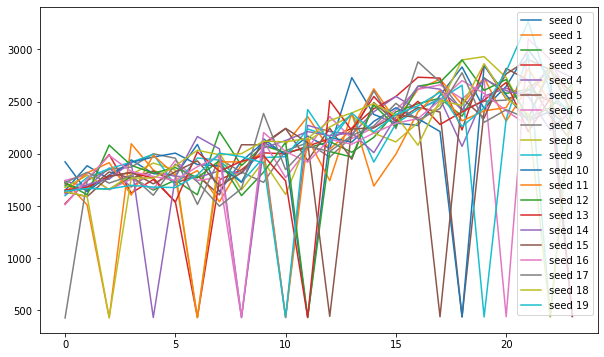

In [78]:
plt.figure(figsize=(10, 6)) 
p_y=[]
for seed in range(20):
    tf.random.set_seed(seed)
    lags = [24]*24
    leads = range(1,25)
    cnn_model = AutoCNN(data_name='data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
    cnn_model.run(True, lags,leads)
    py_new = cnn_model.get_predict()
    p_y.append(py_new)
    plt.plot(p_y[-1],label='seed '+str(seed))
plt.legend()

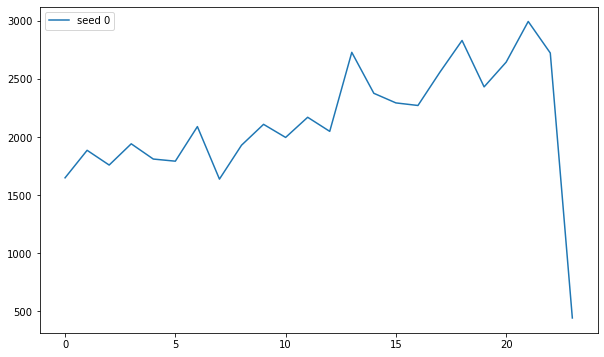

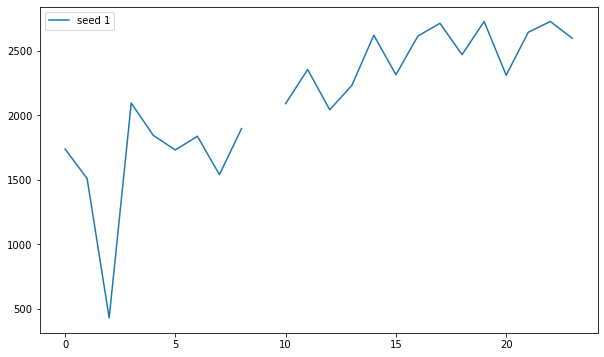

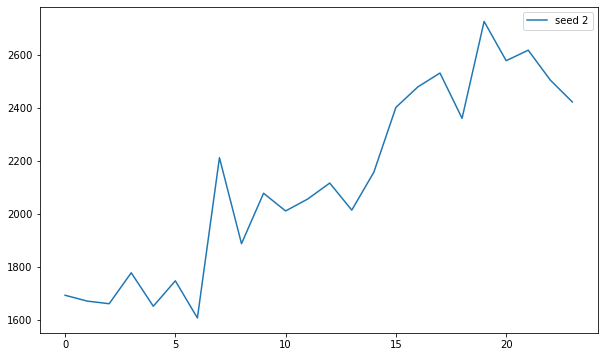

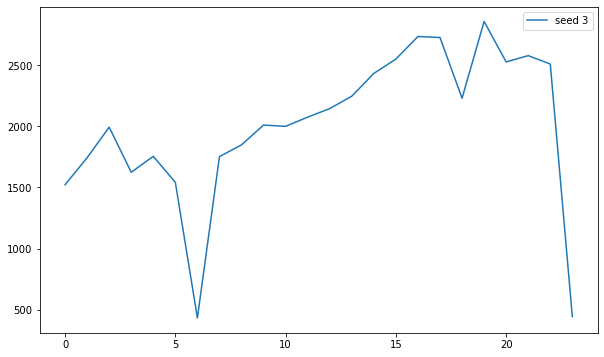

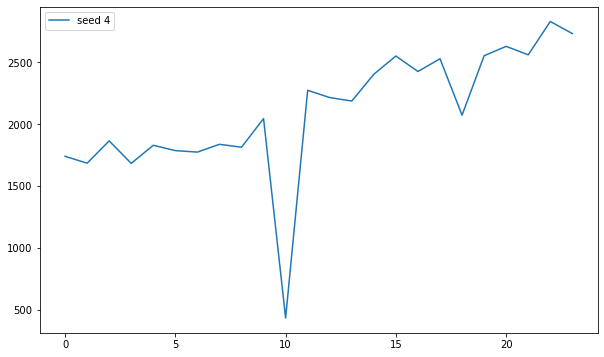

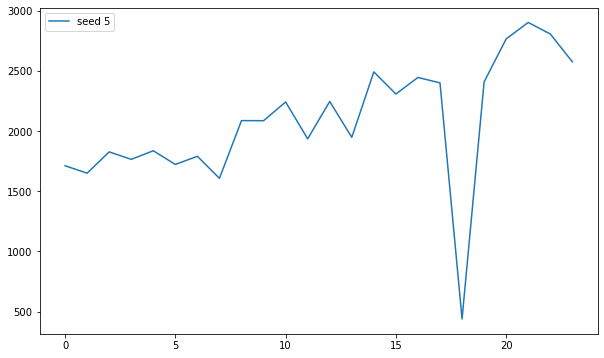

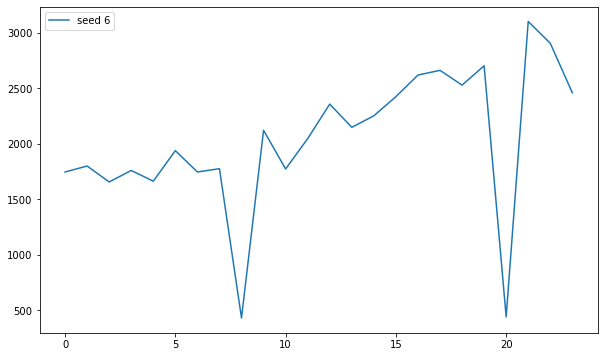

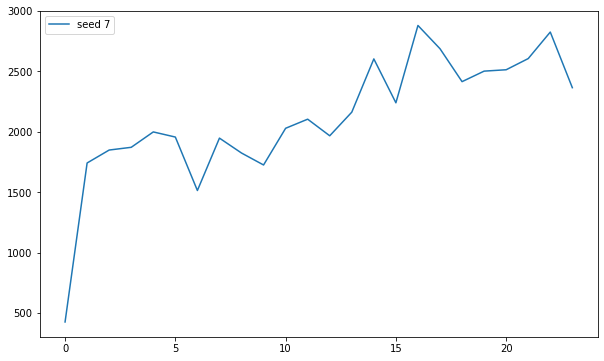

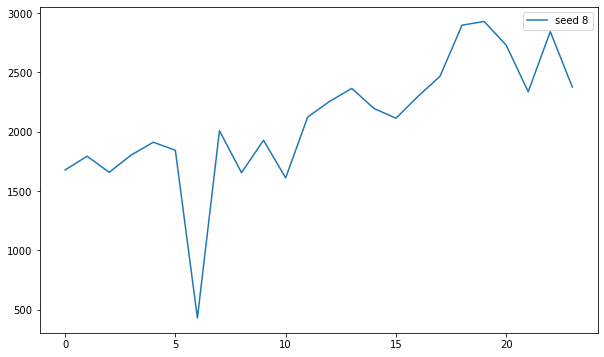

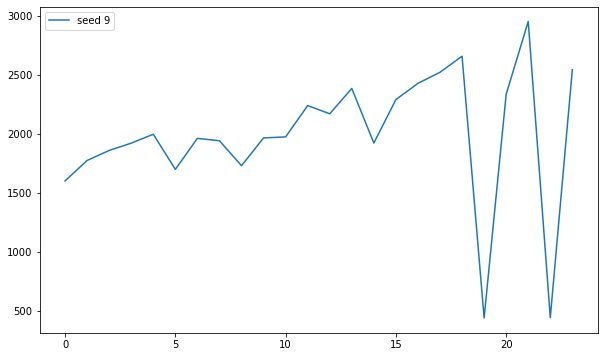

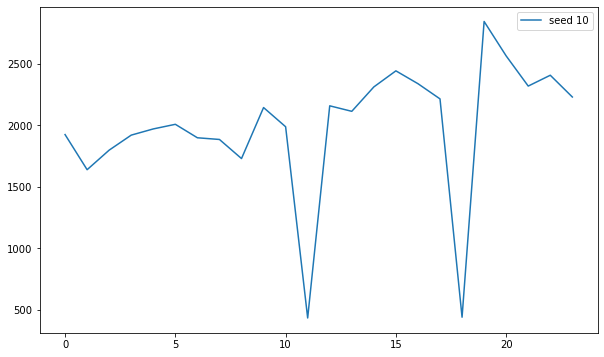

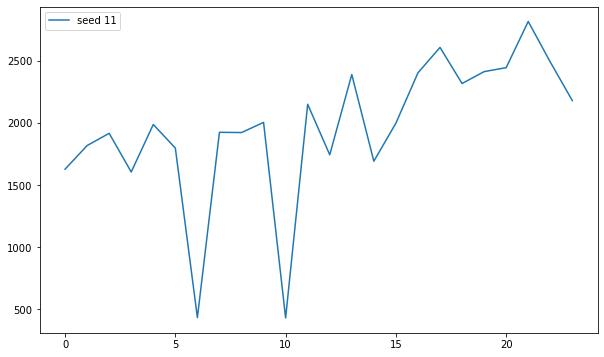

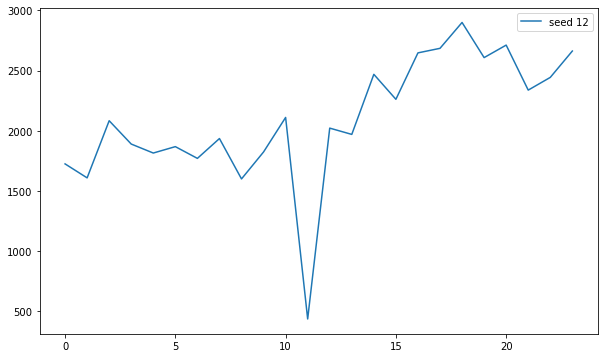

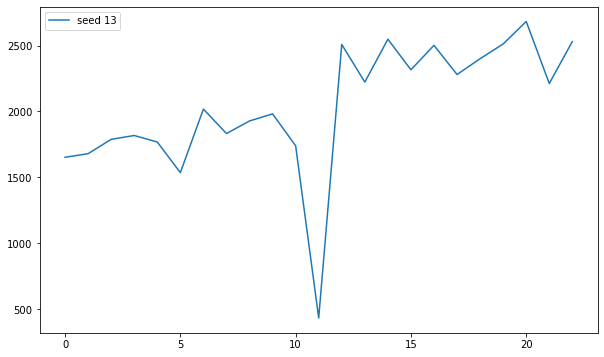

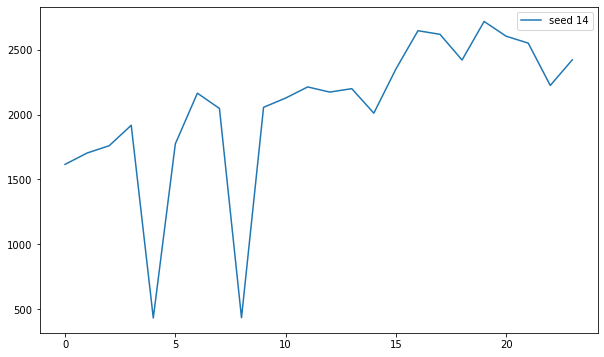

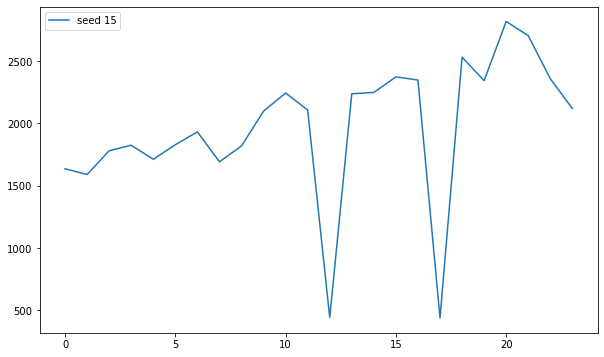

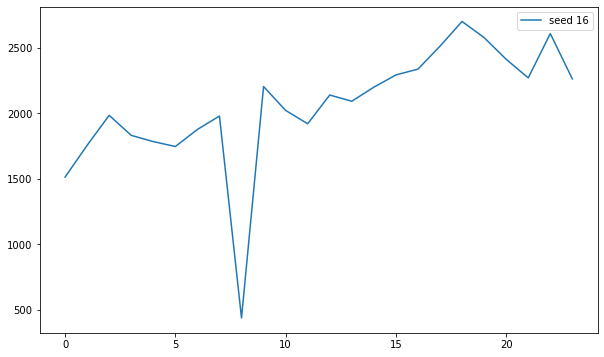

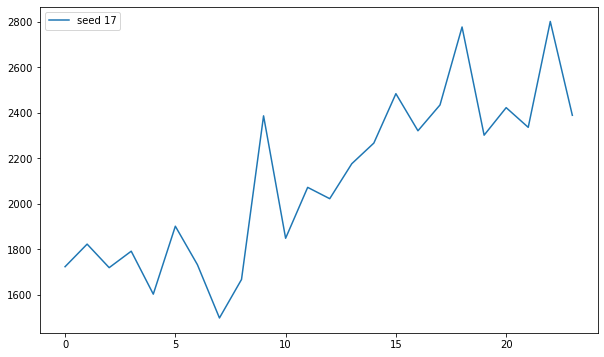

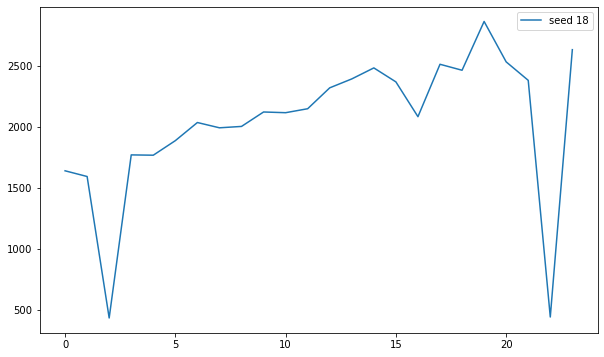

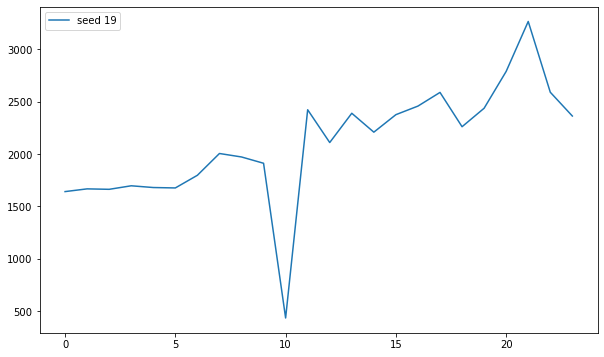

In [79]:
for i in range(20):
    plt.figure(figsize=(10, 6)) 
    plt.plot(p_y[i],label='seed '+str(i))
    plt.legend()

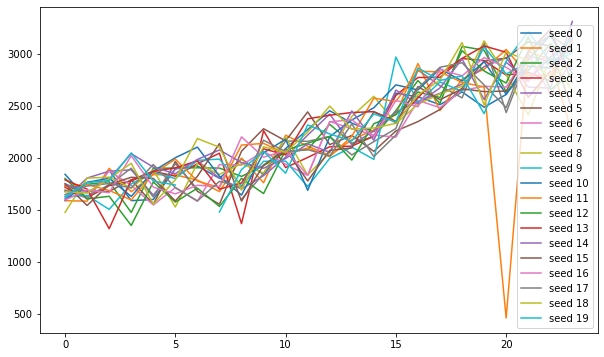

In [93]:
plt.figure(figsize=(10, 6)) 
p_y_2=[]
for seed in range(20):
    tf.random.set_seed(seed)
    lags = [12]*24
    leads = range(1,25)
    cnn_model = AutoCNN(data_name='data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
    cnn_model.run(True, lags,leads)
    py_new = cnn_model.get_predict()
    p_y_2.append(py_new)
    plt.plot(p_y_2[-1],label='seed '+str(seed))
plt.legend()

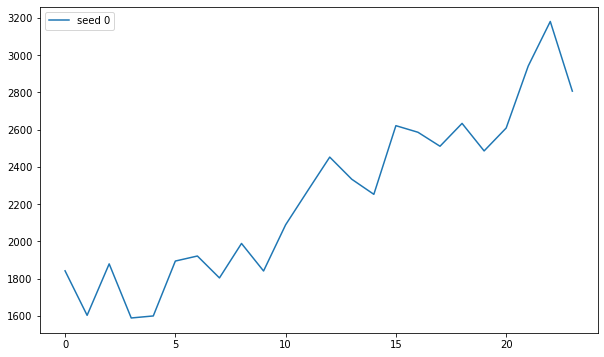

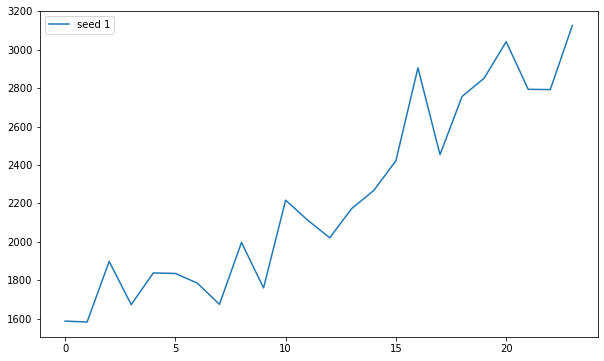

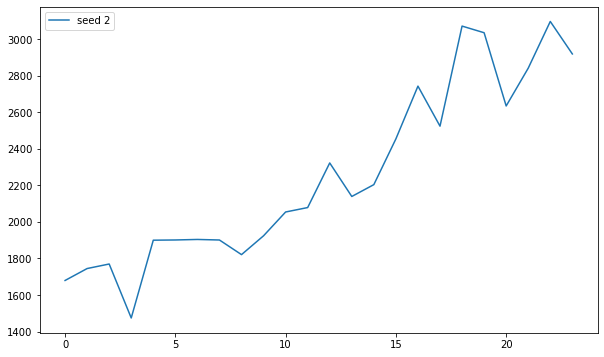

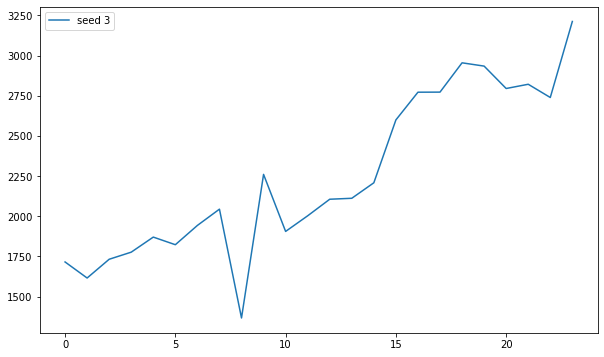

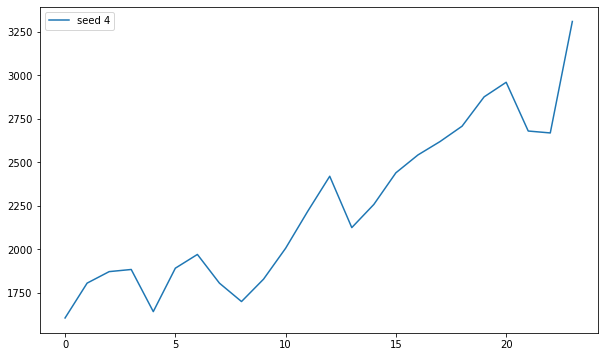

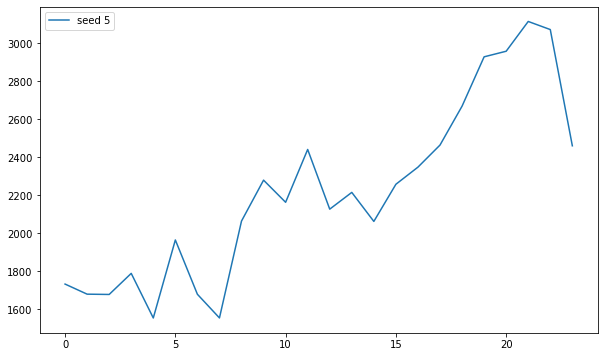

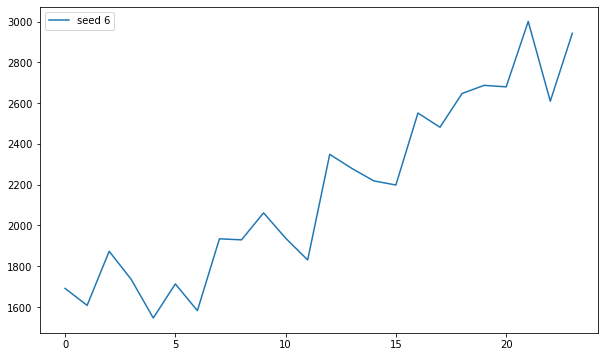

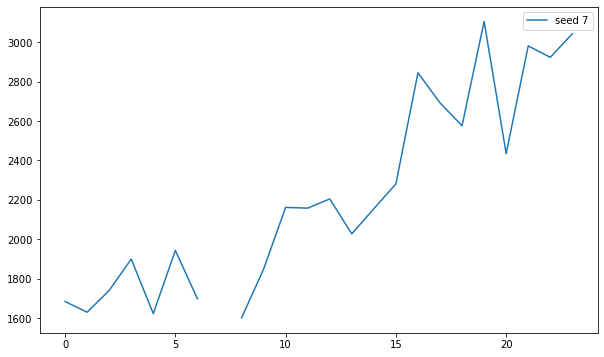

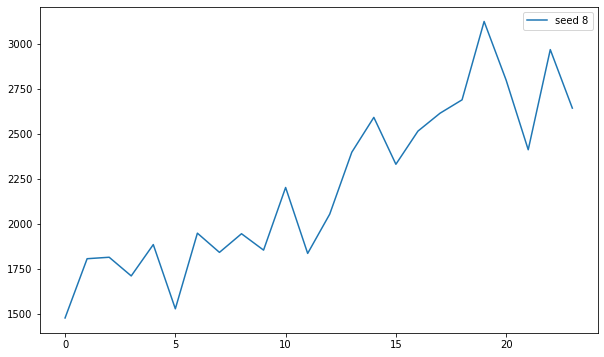

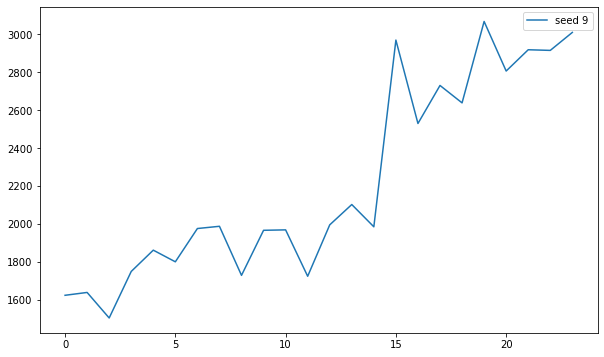

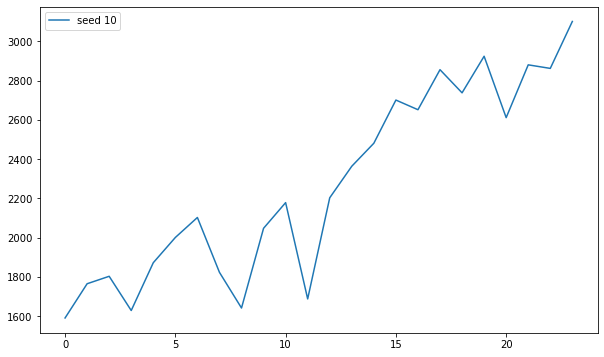

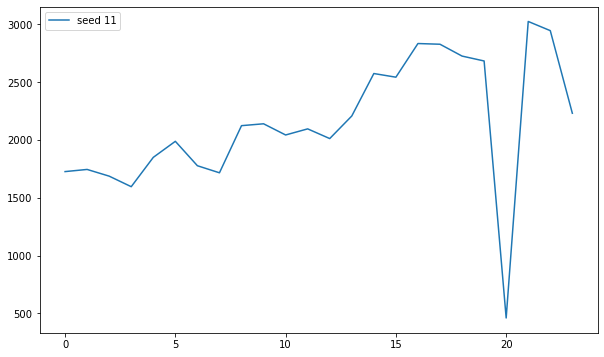

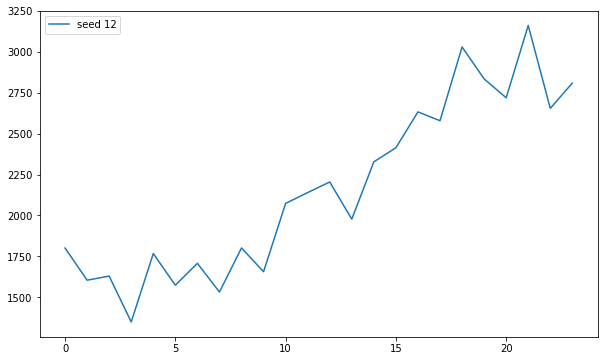

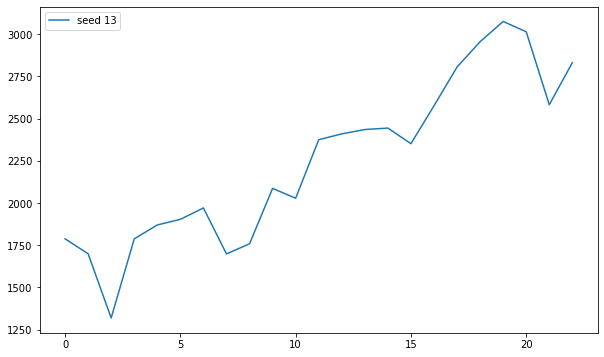

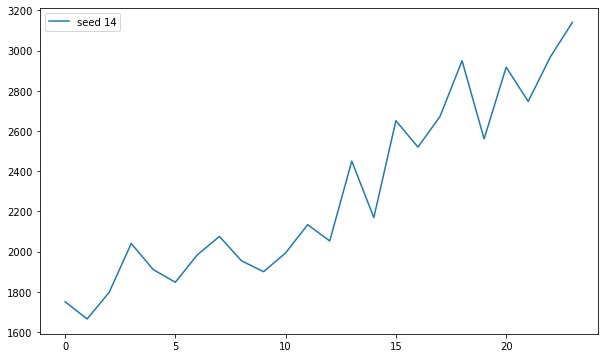

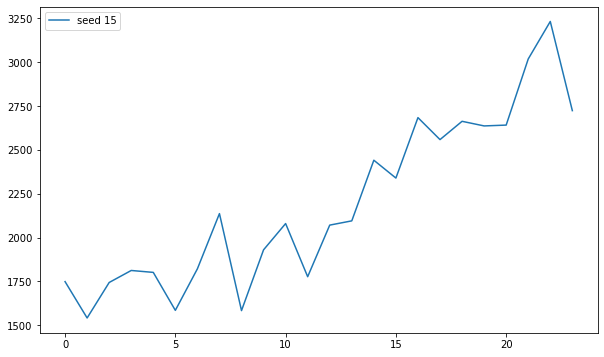

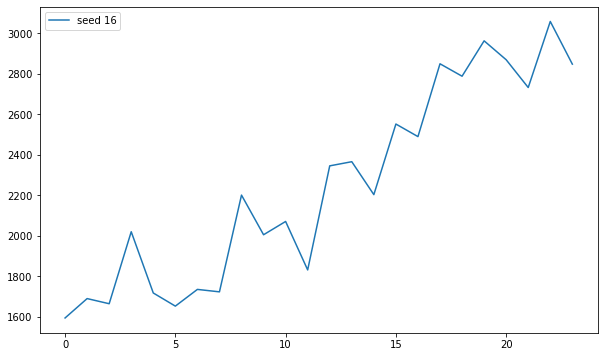

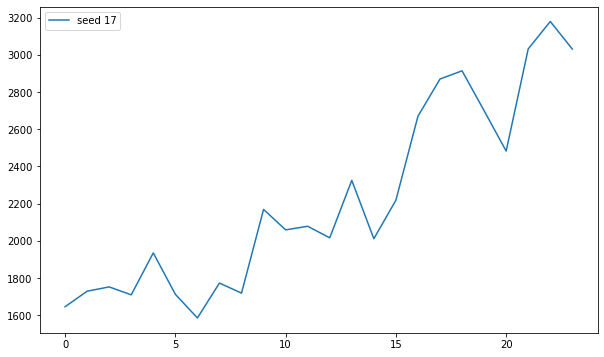

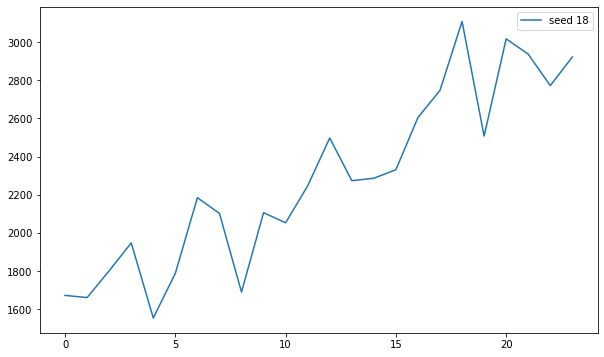

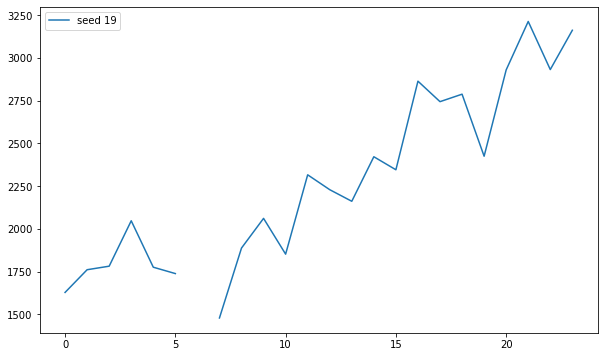

In [94]:
for i in range(20):
    plt.figure(figsize=(10, 6)) 
    plt.plot(p_y_2[i],label='seed '+str(i))
    plt.legend()

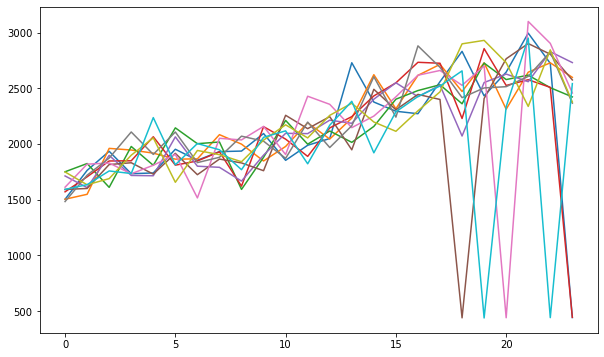

In [107]:
plt.figure(figsize=(10, 6)) 
p_y_3=[]
for seed in range(10):
    tf.random.set_seed(seed)
    lags = [12]*12+[24]*12
    leads = range(1,25)
    cnn_model = AutoCNN(data_name='data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
    cnn_model.run(True, lags,leads)
    py_new = cnn_model.get_predict()
    p_y_3.append(py_new)
    plt.plot(p_y_3[-1],label='seed '+str(seed))

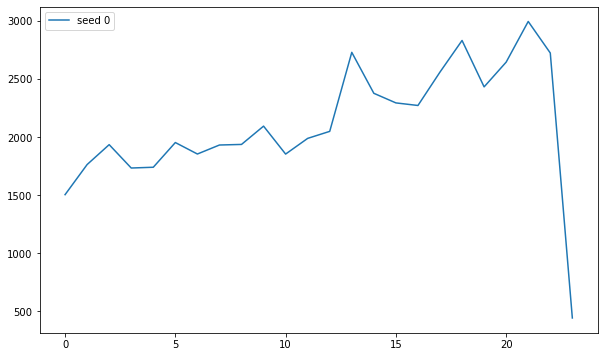

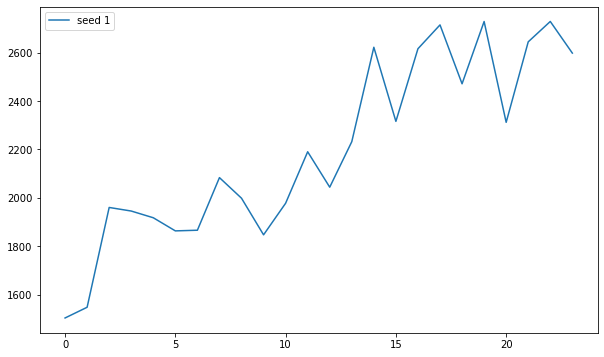

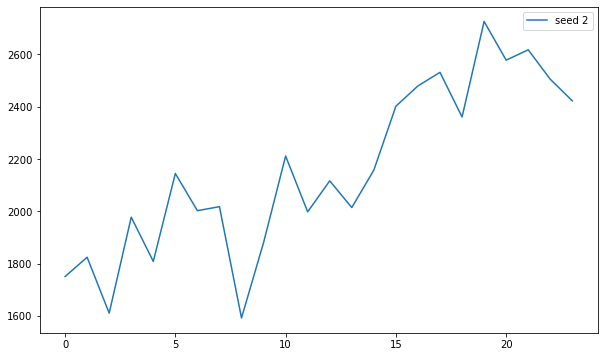

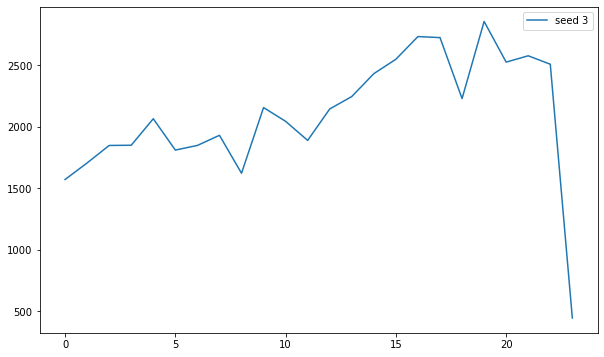

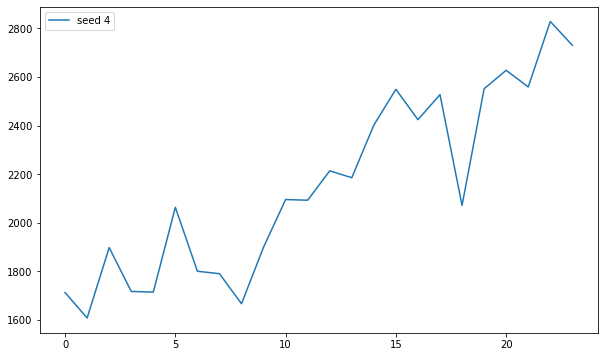

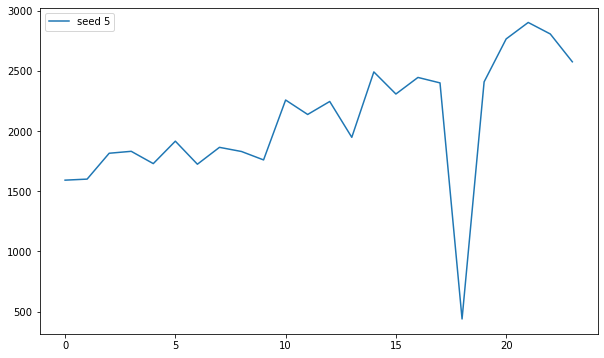

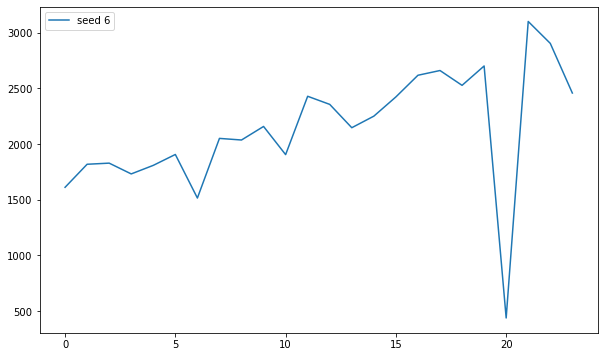

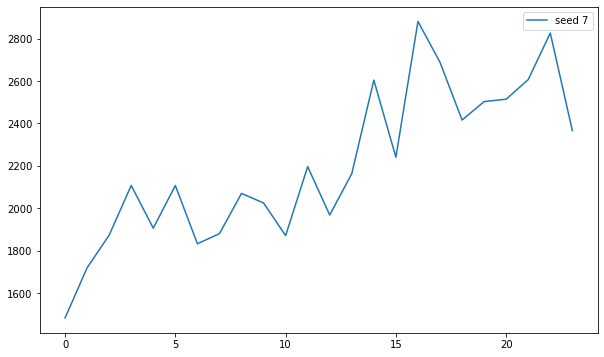

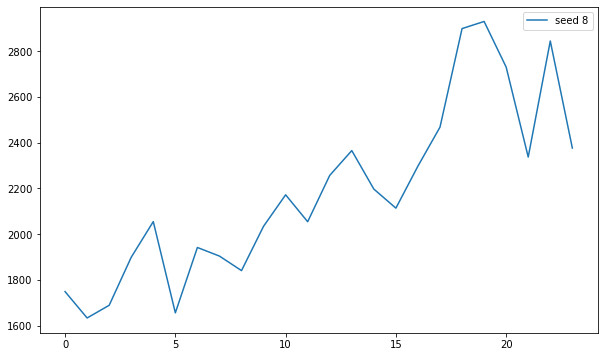

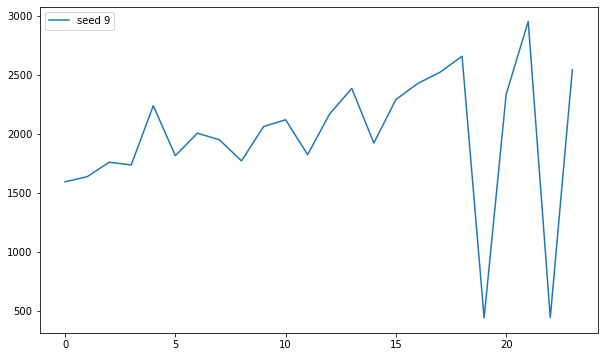

In [109]:
for i in range(10):
    plt.figure(figsize=(10, 6)) 
    plt.plot(p_y_3[i],label='seed '+str(i))
    plt.legend()